## MVP

- The goal of this project is to detect the ransomware transactions.
- To start tackling the problem, we performed exploratory data analysis to get an initial understanding of the dataset.
- In this notebook, we show the followign:
    1. Data distribution. 
    2. How we dealt with categorical data
    3. The score of a vanilla knn model.

### Imports

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [6]:
df = pd.read_csv(r'C:\Users\elaaf\Desktop\SDS\extra\BitcoinHeistData.csv')
#df = pd.read_csv("/Users/muntaha/Documents/BitcoinHeistData.csv")

In [7]:
df.shape

(2916697, 10)

In [8]:
df.info(show_counts =True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   address    2916697 non-null  object 
 1   year       2916697 non-null  int64  
 2   day        2916697 non-null  int64  
 3   length     2916697 non-null  int64  
 4   weight     2916697 non-null  float64
 5   count      2916697 non-null  int64  
 6   looped     2916697 non-null  int64  
 7   neighbors  2916697 non-null  int64  
 8   income     2916697 non-null  float64
 9   label      2916697 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 222.5+ MB


In [9]:
len(df.address.unique()) #the address is not unique

2631095

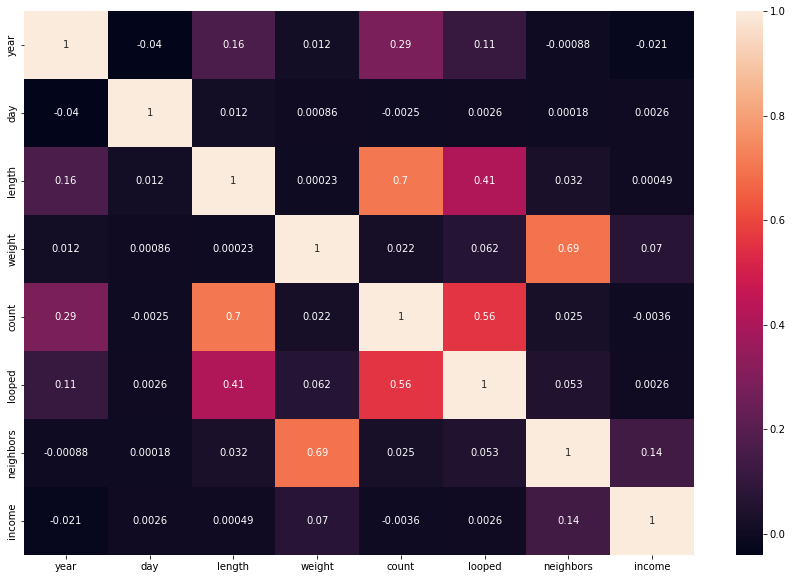

In [11]:
plt.figure(figsize=(15,10));
sns.heatmap(df.corr(), annot=True);

### Ransomware Distribution

In [13]:
to_plot = df.groupby(['label'])['address'].count().drop('white').sort_values(ascending=False)
to_plot

label
paduaCryptoWall                12390
montrealCryptoLocker            9315
princetonCerber                 9223
princetonLocky                  6625
montrealCryptXXX                2419
montrealNoobCrypt                483
montrealDMALockerv3              354
montrealDMALocker                251
montrealSamSam                    62
montrealGlobeImposter             55
montrealCryptoTorLocker2015       55
montrealGlobev3                   34
montrealGlobe                     32
montrealWannaCry                  28
montrealRazy                      13
montrealAPT                       11
paduaKeRanger                     10
montrealFlyper                     9
montrealXTPLocker                  8
montrealXLockerv5.0                7
montrealCryptConsole               7
montrealVenusLocker                7
montrealEDA2                       6
montrealJigSaw                     4
paduaJigsaw                        2
montrealSam                        1
montrealXLocker                 

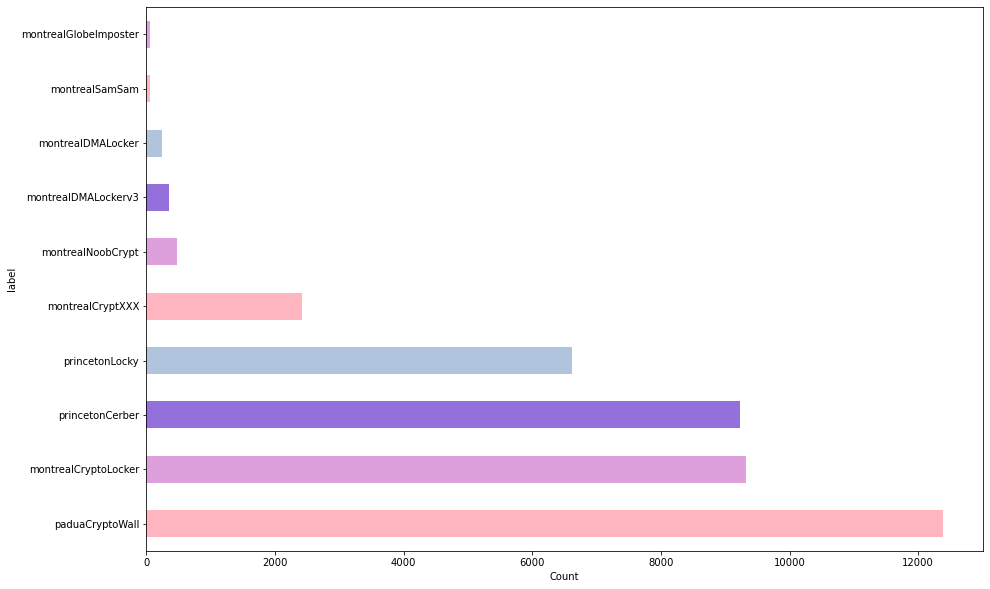

In [17]:
plt.figure(figsize=(15,10));
plt.xlabel('Count')
to_plot[:10].plot(kind='barh',color=['lightpink','plum', 'mediumpurple','lightsteelblue']);

### Changing labels to 0 and 1

In [19]:
unique_label = list(set(df.label))

d = {}

for i in unique_label:
    if i != 'white':
        d[i] = 1
    else:
        d[i] = 0
d

{'montrealCryptXXX': 1,
 'paduaJigsaw': 1,
 'montrealXLocker': 1,
 'montrealXLockerv5.0': 1,
 'montrealCryptoTorLocker2015': 1,
 'montrealGlobeImposter': 1,
 'montrealComradeCircle': 1,
 'paduaKeRanger': 1,
 'montrealCryptoLocker': 1,
 'princetonLocky': 1,
 'montrealSamSam': 1,
 'montrealGlobe': 1,
 'montrealCryptConsole': 1,
 'montrealDMALockerv3': 1,
 'montrealNoobCrypt': 1,
 'white': 0,
 'montrealFlyper': 1,
 'princetonCerber': 1,
 'montrealGlobev3': 1,
 'montrealRazy': 1,
 'montrealDMALocker': 1,
 'montrealWannaCry': 1,
 'montrealVenusLocker': 1,
 'paduaCryptoWall': 1,
 'montrealAPT': 1,
 'montrealXTPLocker': 1,
 'montrealEDA2': 1,
 'montrealJigSaw': 1,
 'montrealSam': 1}

In [20]:
df.label.replace(d, inplace=True)

<AxesSubplot:ylabel='address'>

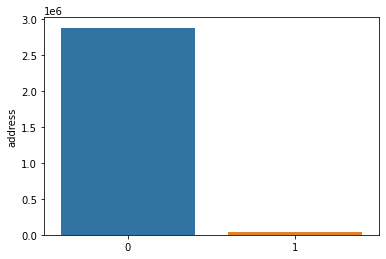

In [21]:
labels_dist = df.groupby(['label'])['address'].count()
sns.barplot(y = labels_dist, x = [0,1])

In [22]:
labels_dist

label
0    2875284
1      41413
Name: address, dtype: int64

In [25]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   address    2916697 non-null  object 
 1   year       2916697 non-null  int64  
 2   day        2916697 non-null  int64  
 3   length     2916697 non-null  int64  
 4   weight     2916697 non-null  float64
 5   count      2916697 non-null  int64  
 6   looped     2916697 non-null  int64  
 7   neighbors  2916697 non-null  int64  
 8   income     2916697 non-null  float64
 9   label      2916697 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 222.5+ MB


C:\Users\elaaf\AppData\Local\Temp/ipykernel_28264/274559223.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax = ax);


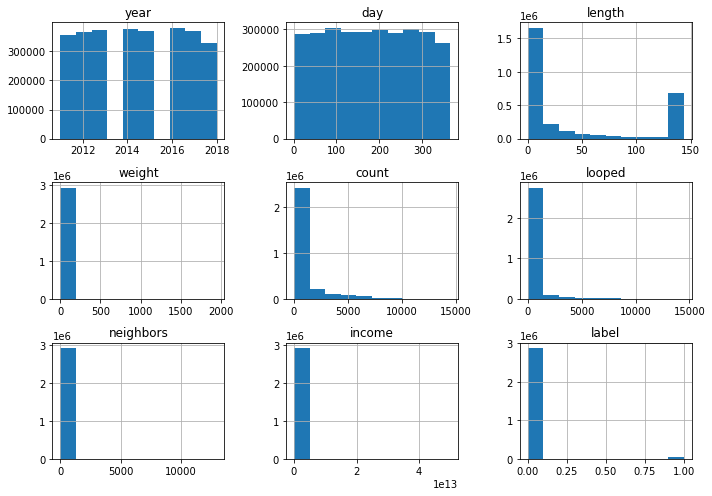

In [27]:
fig = plt.figure(figsize = (10,7));
ax = fig.gca();
df.hist(ax = ax);
plt.tight_layout();

## Training the knn model

### Splitting the data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label','address']), df['label'], 
                                                    test_size = 0.25, random_state=42)

### Scaling the data before Applying knn

In [ ]:
k_range = list(range(1, 100))
print(k_range)


KNeighborsClassifier()
